In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel #, AutoTokenizer

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

In [3]:
model = TFBertModel.from_pretrained("bert-base-multilingual-uncased", output_hidden_states = True)

Some layers from the model checkpoint at bert-base-multilingual-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [5]:
with open('Korean_movie_reviews_2016.txt', encoding='utf-8') as f:
    docs = [doc.strip().split('\t') for doc in f ]
    docs = [(doc[0], int(doc[1])) for doc in docs if len(doc) == 2]
    texts, labels = zip(*docs)

In [6]:
texts=texts[:2000]

In [7]:
labels=labels[:2000]

In [8]:
# for layer in model.layers:
#     layer.trainable=False

In [8]:
tokenized_data = tokenizer(texts, return_tensors="np", max_length=20, padding='max_length', truncation=True)

In [9]:
tokenized_data

{'input_ids': array([[  101,  1170, 46188, ..., 97104,   102,     0],
       [  101, 47529,  1175, ..., 40049, 97104,   102],
       [  101,  1175, 29347, ..., 97107, 16801,   102],
       ...,
       [  101, 96314,  1180, ...,     0,     0,     0],
       [  101, 41912,  1174, ..., 35945, 18501,   102],
       [  101,  1174, 65633, ..., 63277, 40815,   102]]), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, ..., 1, 1, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])}

In [10]:
outputs = model(tokenized_data)

In [11]:
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

### 마지막 인코더 블록의 결과물 사용하기

In [11]:
features1 = outputs.last_hidden_state[:,0,:].numpy()

In [12]:
features1.shape

(2000, 768)

In [13]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features1, labels, test_size=0.2, random_state=0)

In [14]:
from sklearn.linear_model import LogisticRegression
lr2 = LogisticRegression(C=1, penalty='l2', solver='saga', max_iter=10000)
lr2.fit(train_features, train_labels)

LogisticRegression(C=1, max_iter=10000, solver='saga')

In [17]:
pred_labels = lr2.predict(test_features)
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.61      0.66      0.64       192
           1       0.66      0.62      0.64       208

    accuracy                           0.64       400
   macro avg       0.64      0.64      0.64       400
weighted avg       0.64      0.64      0.64       400



### 풀러 층의 결과물 사용해 보기

In [15]:
features2 = outputs.pooler_output.numpy()

In [16]:
train_features2, test_features2, train_labels2, test_labels2 = train_test_split(features2, labels, test_size=0.2, random_state=0)

In [17]:
lr2 = LogisticRegression(C=1, penalty='l2', solver='saga', max_iter=10000)
lr2.fit(train_features2, train_labels2)

LogisticRegression(C=1, max_iter=10000, solver='saga')

In [18]:
pred_labels2 = lr2.predict(test_features2)
from sklearn.metrics import classification_report
print(classification_report(test_labels2, pred_labels2))

              precision    recall  f1-score   support

           0       0.59      0.68      0.63       192
           1       0.65      0.56      0.60       208

    accuracy                           0.62       400
   macro avg       0.62      0.62      0.62       400
weighted avg       0.62      0.62      0.62       400



### FNN 사용해 보기

In [20]:
from tensorflow.keras.utils import to_categorical
y_one_hot = to_categorical(labels)

In [21]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(features, y_one_hot, test_size=0.2)

In [22]:
from tensorflow.keras import models
model = models.Sequential()

In [23]:
from tensorflow.keras import layers
model.add(layers.Dense(32, activation = 'tanh', input_shape=(X_train.shape[1],)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(64, activation = 'tanh'))
model.add(layers.Dense(2, activation='softmax'))

In [25]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
40/40 [==============================] - 1s 6ms/step - loss: 0.7006 - accuracy: 0.5305 - val_loss: 0.6912 - val_accuracy: 0.5625
Epoch 2/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6910 - accuracy: 0.5461 - val_loss: 0.6845 - val_accuracy: 0.5688
Epoch 3/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6850 - accuracy: 0.5617 - val_loss: 0.6797 - val_accuracy: 0.6125
Epoch 4/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6787 - accuracy: 0.5969 - val_loss: 0.6750 - val_accuracy: 0.6344
Epoch 5/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6729 - accuracy: 0.6016 - val_loss: 0.6705 - val_accuracy: 0.6344
Epoch 6/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6682 - accuracy: 0.6055 - val_loss: 0.6668 - val_accuracy: 0.6375
Epoch 7/50
40/40 [==============================] - 0s 2ms/step - loss: 0.6627 - accuracy: 0.6133 - val_loss: 0.6638 - val_accuracy: 0.6594
Epoch 8/50
40/40 [==

In [27]:
model.evaluate(X_test,y_test)

13/13 [==============================] - 0s 1ms/step - loss: 0.6098 - accuracy: 0.6975


[0.6098171472549438, 0.6974999904632568]

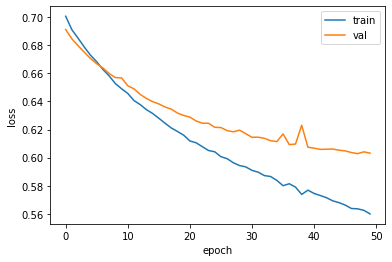

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

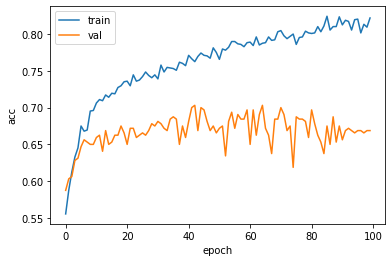

In [57]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train','val'])
plt.show()

## BoW 모형 사용해보기

In [62]:
selected_texts = texts[:2000]

In [63]:
# To split the data into training and test datasets
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(selected_texts, selected_labels, test_size=0.2, random_state=0)

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(min_df=1, ngram_range=(1,1)) 
train_tf_features = tf_vectorizer.fit_transform(train_texts)
test_tf_features = tf_vectorizer.transform(test_texts)

In [66]:
from sklearn.linear_model import LogisticRegression
lr2 = LogisticRegression(C=10, penalty='l2', solver='sag', max_iter=2000) # Ridge regression
lr2.fit(train_tf_features, train_labels) # 학습
pred_labels = lr2.predict(test_tf_features)

In [67]:
from sklearn.metrics import accuracy_score
print('Misclassified samples: {} out of {}'.format((pred_labels != test_labels).sum(),len(test_labels)))
print('Accuracy: %.2f' % accuracy_score(test_labels, pred_labels))

Misclassified samples: 88 out of 400
Accuracy: 0.78
